# p33_35
- Ok I think I need to compute all the gradients?

In [1]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [2]:
model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
# model_id = "gpt2"

In [3]:
# Random init
# model_config = GPT2Config() #Full sized model
# model = GPT2LMHeadModel(model_config).to(device) #Ok i should see what happens with full and pretrained model. 
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Not quite working for Llama, will take some noodling
# model_config  = LlamaConfig.from_dict(config_dict)
# model = LlamaForCausalLM(model_config).to(device) 
# tokenizer = AutoTokenizer.from_pretrained(model_id)

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [4]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


In [5]:
prompt2="The capital of France is Paris"
input_ids=tokenizer.encode(prompt2, return_tensors="pt")

out=model(input_ids.to(device), labels=input_ids.to(device))
out.loss.backward()

param_dict = {name: param for name, param in model.named_parameters()}
param_dict_2d={k:v for k,v in param_dict.items() if v.ndim>1}
grad_dict = {}

for p in param_dict:
    if param_dict[p].requires_grad:
        grad_dict[p] = param_dict[p].grad

grad_count=0
for g in grad_dict:
    grad_count+=grad_dict[g].numel()

grad_count/1e9

1.2358144

In [6]:
def get_random_param_name(param_dict_2d):
    random_layer_index=np.random.choice(len(param_dict_2d.keys()))
    random_layer_name=list(param_dict_2d.keys())[random_layer_index]
    return random_layer_name

def get_random_indices(t):
    random_i=np.random.choice(t.shape[0])
    random_j=np.random.choice(t.shape[1])
    return random_i, random_j

def top_n_abs_indices(arr, n=128):
    flat_indices = np.argsort(np.abs(arr).flatten())[-n:][::-1]
    return np.column_stack(np.unravel_index(flat_indices, arr.shape))

In [7]:
with torch.no_grad():
    out=model(input_ids.to(device))
probs = F.softmax(out.logits.detach().cpu(), dim=-1)
my_loss=-np.log(probs[0, 5, 12366].item())

In [8]:
my_loss

np.float64(0.9376176141361524)

In [9]:
p

'model.norm.weight'

In [10]:
# p='model.layers.15.mlp.gate_proj.weight'
# p='model.layers.15.mlp.up_proj.weight'
p='model.layers.15.mlp.down_proj.weight'

In [11]:
top_indices=top_n_abs_indices(grad_dict[p].detach().cpu().float().numpy())

In [12]:
top_indices.shape

(128, 2)

Gotta make sure I zero gradients as I go here!

In [13]:
top_index_1=10 
top_index_2=12

i_choice_1=top_indices[top_index_1][0]
j_choice_1=top_indices[top_index_1][1]
i_choice_2=top_indices[top_index_2][0]
j_choice_2=top_indices[top_index_2][1]

og_value_1=param_dict[p][i_choice_1, j_choice_1].item()
og_value_2=param_dict[p][i_choice_2, j_choice_2].item()

In [14]:
# out=model(input_ids.to(device), labels=input_ids.to(device))
# out.loss.backward()

In [15]:
xs1=np.arange(-1.007, 4, 0.01) #high rez version -> 0.01
xs2=np.arange(-1.007, 4, 0.01)
model.eval()
losses=[]; all_probs_1=[]; grads_1=[]; grads_2=[]
for x1 in tqdm(xs1):
    losses.append([]); grads_1.append([]); grads_2.append([])
    for x2 in xs2:
        for k,v in grad_dict.items():
            v.zero_()
            
        with torch.no_grad():
            param_dict[p][i_choice_1, j_choice_1]=x1
            param_dict[p][i_choice_2, j_choice_2]=x2
        
        out=model(input_ids.to(device), labels=input_ids.to(device))
        
        # losses.append(out.loss.item())
        #Loss for just paris token
        probs = F.softmax(out.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, 5, 12366])
        losses[-1].append(my_loss.item())
        # all_probs_1.append(probs[0, 5, 12366])

        out.loss.backward()
        grads_1[-1].append(grad_dict[p][i_choice_1, j_choice_1].item())
        grads_2[-1].append(grad_dict[p][i_choice_2, j_choice_2].item())

with torch.no_grad():
    param_dict[p][i_choice_1, j_choice_1]=og_value_1
    param_dict[p][i_choice_2, j_choice_2]=og_value_2
    
losses=np.array(losses); grads_1=np.array(grads_1); grads_2=np.array(grads_2); 

  0%|                                                    | 0/501 [00:00<?, ?it/s]/tmp/ipykernel_69369/364337328.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])
100%|████████████████████████████████████████| 501/501 [6:42:25<00:00, 48.19s/it]


In [16]:
np.save('p_33_35_grads_1_2.npy', grads_1)
np.save('p_33_35_grads_2_2.npy', grads_2)
xy=np.vstack((xs1, xs2))
np.save('p_33_35_xy_2.npy', xy)

In [23]:
grads_1.shape

(501, 501)

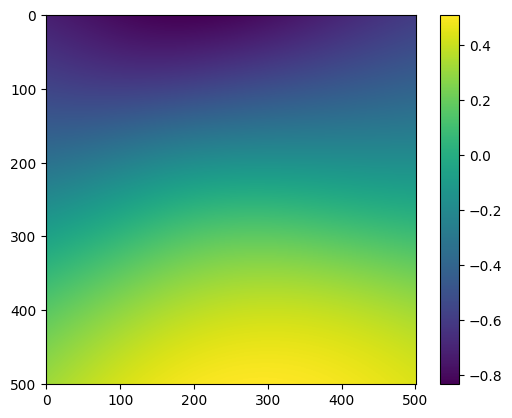

In [25]:
plt.imshow(grads_1); plt.colorbar()

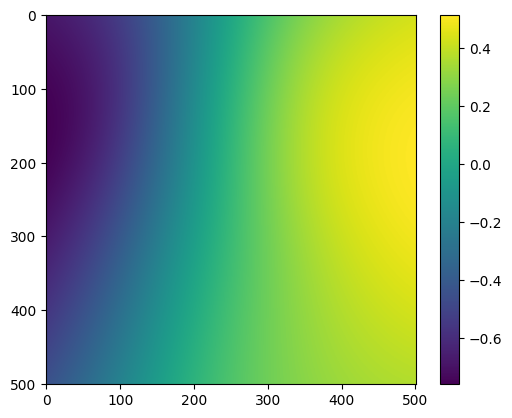

In [26]:
plt.imshow(grads_2); plt.colorbar()

In [27]:
xy

array([[-1.007, -0.997, -0.987, ...,  3.973,  3.983,  3.993],
       [-1.007, -0.997, -0.987, ...,  3.973,  3.983,  3.993]],
      shape=(2, 501))

In [17]:
xs1.shape

(501,)

In [18]:
losses.shape

(501, 501)

In [19]:
# Create figure without borders/margins
plt.figure(frameon=False)

# Create axes without borders/frames
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)

# Display image
plt.imshow(np.rot90(losses))

# Save with tight layout and no extra space
# plt.savefig('p_24_28_losses_5.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

In [20]:
xs1.shape

(501,)

In [21]:
xy=np.vstack((xs1, xs2))
# np.save('p_24_28_losses_5xy.npy', xy)

In [22]:
# np.save('p_24_28_losses_5.npy', losses)